#**Step 1: Install All the Required Packages**

In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 83.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

#**Step 2: Import All the Required Libraries**

In [ ]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

/usr/local/lib/python3.10/dist-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


/usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


#**In case of Llama 2, the following prompt template is used for the chat models**

System Prompt (optional) to guide the model


User prompt (required) to give the instruction


Model Answer (required)

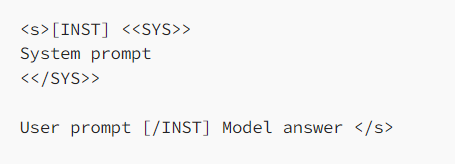

#We will reformat our instruction dataset to follow Llama 2 template.

I have already Processed the Dataset in the "Loading_Dataset" Notebook and Coverted it into ".csv" file.

Here We are reformatting the datasets into the standard from inputs supported by the Base LLama2 Model.

To know how this dataset was created, you can check this notebook.  

https://colab.research.google.com/drive/1Ad7a9zMmkxuXTOh1Z7-rNSICA4dybpM2?usp=sharing

### Note: You don’t need to follow a specific prompt template if you’re using the base Llama 2 model instead of the chat version.

In [ ]:
# !pip install -q datasets
!pip install pandas pyarrow fastparquet
# !huggingface-cli login



  Using cached fastparquet-2024.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd

# Specify the path to your Parquet file
file_path = '/content/dataset.csv'

# Read the Parquet file
df = pd.read_csv(file_path)

# Print the dataframe
print(df)



       Unnamed: 0                                        instruction  \
0               0  Create a function to calculate the sum of a se...   
1               1  Generate a Python code for crawling a website ...   
2               2  Create a Python list comprehension to get the ...   
3               3   Generate a python script to perform this action.   
4               4  Write a python script to generates random numb...   
...           ...                                                ...   
18607       18607  Generate a loop in Python which iterates throu...   
18608       18608  Can you design a function in Python to sort a ...   
18609       18609  Generate a Python function to search an array ...   
18610       18610  Develop an HTTP API in Python to retrieve the ...   
18611       18611  Create a classification algorithm in Python to...   

                                                   input  \
0                                        [1, 2, 3, 4, 5]   
1      website:

In [ ]:
# Shuffle the dataset and slice it
# dataset = dataset['train'].shuffle(seed=42).select(range(1000))
inst = df["instruction"]
output=df["output"]
prompt=df["prompt"]
print(df.shape[0])
# print(inst)
reformatted_segments=[]
for i in range (df.shape[0]):

  human_text=inst[i]
  assistant_text=prompt[i]
  code_text=output[i]
  reformatted_segments.append("<s>[INST] {human_text} [/INST] {assistant_text} {code_text}</s>")


# Apply the transformation
transformed_dataset = reformatted_segments
print(transformed_dataset)
print(len(transformed_dataset))

18612
['<s>[INST] {human_text} [/INST] {assistant_text} {code_text}</s>', '<s>[INST] {human_text} [/INST] {assistant_text} {code_text}</s>', '<s>[INST] {human_text} [/INST] {assistant_text} {code_text}</s>', '<s>[INST] {human_text} [/INST] {assistant_text} {code_text}</s>', '<s>[INST] {human_text} [/INST] {assistant_text} {code_text}</s>', '<s>[INST] {human_text} [/INST] {assistant_text} {code_text}</s>', '<s>[INST] {human_text} [/INST] {assistant_text} {code_text}</s>', '<s>[INST] {human_text} [/INST] {assistant_text} {code_text}</s>', '<s>[INST] {human_text} [/INST] {assistant_text} {code_text}</s>', '<s>[INST] {human_text} [/INST] {assistant_text} {code_text}</s>', '<s>[INST] {human_text} [/INST] {assistant_text} {code_text}</s>', '<s>[INST] {human_text} [/INST] {assistant_text} {code_text}</s>', '<s>[INST] {human_text} [/INST] {assistant_text} {code_text}</s>', '<s>[INST] {human_text} [/INST] {assistant_text} {code_text}</s>', '<s>[INST] {human_text} [/INST] {assistant_text} {code_

#**How to fine tune Llama 2**

- Free Google Colab offers a 15GB Graphics Card (Limited Resources --> Barely enough to store Llama 2–7b’s weights)

- We also need to consider the overhead due to optimizer states, gradients, and forward activations

- Full fine-tuning is not possible here: we need parameter-efficient fine-tuning (PEFT) techniques like LoRA or QLoRA.

- To drastically reduce the VRAM usage, we must fine-tune the model in 4-bit precision, which is why we’ll use QLoRA here.

#**Step 3**

1. Load a llama-2-7b-chat-hf model (chat model)
2. Train it on the mlabonne/guanaco-llama2-1k (1,000 samples), which will produce our fine-tuned model Llama-2-7b-chat-finetune

QLoRA will use a rank of 64 with a scaling parameter of 16. We’ll load the Llama 2 model directly in 4-bit precision using the NF4 type and train it for one epoch

In [ ]:
# The model that you want to train from the Hugging Face hub
model_name = "NousResearch/Llama-2-7b-chat-hf"

# The instruction dataset to use
dataset_name = "mlabonne/guanaco-llama2-1k"

# Fine-tuned model name
new_model = "Llama-2-7b-chat-finetune"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

#**Step 4:Load everything and start the fine-tuning process**

1. First of all, we want to load the dataset we defined. Here, our dataset is already preprocessed but, usually, this is where you would reformat the prompt, filter out bad text, combine multiple datasets, etc.


2. Then, we’re configuring bitsandbytes for 4-bit quantization.


3. Next, we're loading the Llama 2 model in 4-bit precision on a GPU with the corresponding tokenizer.


4. Finally, we're loading configurations for QLoRA, regular training parameters, and passing everything to the SFTTrainer. The training can finally start!

In [ ]:
# Load dataset (you can process it here)
# dataset = transformed_dataset

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)



In [ ]:
from datasets import Dataset

# Example list dataset
# data = [{"text": "Sample text 1"}, {"text": "Sample text 2"}]

data_dict = [{"text": text} for text in dataset]

# Convert list to Dataset object
trained_dataset = Dataset.from_list(data_dict)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=trained_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

# Train model
trainer.train()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Save trained model
trainer.model.save_pretrained(new_model)

##**Step 5: Check the plots on tensorboard, as follows**

In [ ]:
%load_ext tensorboard
%tensorboard --logdir results/runs

###**Step 6:Use the text generation pipeline to ask questions like “What is a large language model?” Note that I’m formatting the input to match Llama 2 prompt template.**

In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "What is a large language model?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

In [ ]:
# Empty VRAM
del model
del pipe
del trainer
import gc
gc.collect()
gc.collect()

You can train a Llama 2 model on the entire dataset using [mlabonne/guanaco-llama2](https://huggingface.co/datasets/mlabonne/guanaco-llama2)

#**Step 7: Store New Llama2 Model (Llama-2-7b-chat-finetune)**

How can we store our new Llama-2-7b-chat-finetune model now? We need to merge the weights from LoRA with the base model. Unfortunately, as far as I know, there is no straightforward way to do it: we need to reload the base model in FP16 precision and use the peft library to merge everything.

In [ ]:
# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map="cpu",
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

#**Step 8: Push Model to Hugging Face Hub**

Our weights are merged and we reloaded the tokenizer. We can now push everything to the Hugging Face Hub to save our model.

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!huggingface-cli login

model.push_to_hub("entbappy/Llama-2-7b-chat-finetune", check_pr=True)

tokenizer.push_to_hub("entbappy/Llama-2-7b-chat-finetune",check_pr=True)


You can now use this model for inference by loading it like any other Llama 2 model from the Hub.

In [ ]:
!pip install sentence-transformers uvicorn ctransformers langchain python-box streamlit langchain_community huggingface_hub transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 987.6/987.6 kB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.5/366.5 kB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 82.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
from huggingface_hub import hf_hub_download

In [ ]:
HUGGING_FACE_API_KEY = os.environ.get("Hugging_face_Token_For_Reading_Persmission")
model_id = "Riddhankur/llama_2_finetune"
filenames = [".gitattributes","README.md","tokenizer.model","config.json","pytorch_model.bin.index.json",
        "added_tokens.json", "config.json", "generation_config.json",
        "special_tokens_map.json", "tokenizer_config.json","tokenizer.json"
]
for filename in filenames:
        downloaded_model_path = hf_hub_download(
                    repo_id=model_id,
                    filename=filename,
                    token=HUGGING_FACE_API_KEY
        )
        print(downloaded_model_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

/root/.cache/huggingface/hub/models--Riddhankur--llama_2_finetune/snapshots/eabf55f4f68c49f347b6c9cfd8c8a4972fd51d18/.gitattributes


README.md:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

/root/.cache/huggingface/hub/models--Riddhankur--llama_2_finetune/snapshots/eabf55f4f68c49f347b6c9cfd8c8a4972fd51d18/README.md


tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

/root/.cache/huggingface/hub/models--Riddhankur--llama_2_finetune/snapshots/eabf55f4f68c49f347b6c9cfd8c8a4972fd51d18/tokenizer.model


config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

/root/.cache/huggingface/hub/models--Riddhankur--llama_2_finetune/snapshots/eabf55f4f68c49f347b6c9cfd8c8a4972fd51d18/config.json


pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

/root/.cache/huggingface/hub/models--Riddhankur--llama_2_finetune/snapshots/eabf55f4f68c49f347b6c9cfd8c8a4972fd51d18/pytorch_model.bin.index.json


added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

/root/.cache/huggingface/hub/models--Riddhankur--llama_2_finetune/snapshots/eabf55f4f68c49f347b6c9cfd8c8a4972fd51d18/added_tokens.json
/root/.cache/huggingface/hub/models--Riddhankur--llama_2_finetune/snapshots/eabf55f4f68c49f347b6c9cfd8c8a4972fd51d18/config.json


generation_config.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

/root/.cache/huggingface/hub/models--Riddhankur--llama_2_finetune/snapshots/eabf55f4f68c49f347b6c9cfd8c8a4972fd51d18/generation_config.json


special_tokens_map.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

/root/.cache/huggingface/hub/models--Riddhankur--llama_2_finetune/snapshots/eabf55f4f68c49f347b6c9cfd8c8a4972fd51d18/special_tokens_map.json


tokenizer_config.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

/root/.cache/huggingface/hub/models--Riddhankur--llama_2_finetune/snapshots/eabf55f4f68c49f347b6c9cfd8c8a4972fd51d18/tokenizer_config.json


tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

/root/.cache/huggingface/hub/models--Riddhankur--llama_2_finetune/snapshots/eabf55f4f68c49f347b6c9cfd8c8a4972fd51d18/tokenizer.json
